### Airbnb Barcelona Price Prediction
### Task #2
### Problem - Create a pricing model, which can predict the acceptable per night price for Airbnb apartment based on its properties and the offered amenities.
### *Author - Niyaz*
#### "listings" file has only been used because it contains all the necessary information including neighbourhoods, reviews and data from calendar file.

# Setup

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.colors import n_colors
from plotly.subplots import make_subplots
%matplotlib inline
from geopy.distance import great_circle
import datetime
import string
import re 


import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from collections import Counter

from scipy import stats
from scipy.stats import norm, skew
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.impute import KNNImputer

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from IPython.display import HTML

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ragec\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ragec\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [387]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', None)

In [2]:
listings = pd.read_csv('data/listings.csv')

In [9]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16920 entries, 0 to 16919
Data columns (total 75 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            16920 non-null  int64  
 1   listing_url                                   16920 non-null  object 
 2   scrape_id                                     16920 non-null  int64  
 3   last_scraped                                  16920 non-null  object 
 4   source                                        16920 non-null  object 
 5   name                                          16910 non-null  object 
 6   description                                   16834 non-null  object 
 7   neighborhood_overview                         9927 non-null   object 
 8   picture_url                                   16920 non-null  object 
 9   host_id                                       16920 non-null 

In [26]:
listings.head(5)

id                                      listing_url  \
0  673276379194656210  https://www.airbnb.com/rooms/673276379194656210   
1            44192271            https://www.airbnb.com/rooms/44192271   
2            17039441            https://www.airbnb.com/rooms/17039441   
3               18674               https://www.airbnb.com/rooms/18674   
4  553559871868002337  https://www.airbnb.com/rooms/553559871868002337   

        scrape_id last_scraped       source  \
0  20220910194401   2022-09-10  city scrape   
1  20220910194401   2022-09-10  city scrape   
2  20220910194401   2022-09-10  city scrape   
3  20220910194401   2022-09-11  city scrape   
4  20220910194401   2022-09-10  city scrape   

                                                name  \
0                          Habitación muy acogedora.   
1       Cozy terrace apartment Apartamento con patio   
2  Apart. full equipped. 2 min to Subway lines L1...   
3    Huge flat for 8 people close to Sagrada Familia   
4                                  8 lacus, VICTORIA   

                                         description  \
0  Abrace la simplicidad en este lugar tranquilo ...   
1  A private terraced + 2 bedroom ground floor ap...   
2  Precioso apartamento ideal para parejas. Lumin...   
3  110m2 apartment to rent in Barcelona. Located ...   
4  8 apartaments que pretenen recordar la importà...   

                               neighborhood_overview  \
0  El barrio es tranquilo y bien hubicado.   Cerc...   
1  The neighbourhood is quiet with trees. Though ...   
2  La zona dispone de servicios básicos y una exc...   
3  Apartment in Barcelona located in the heart of...   
4                                                NaN   

                                         picture_url    host_id  \
0  https://a0.muscache.com/pictures/miso/Hosting-...   51421682   
1  https://a0.muscache.com/pictures/2e579e6b-b717...  200754964   
2  https://a0.muscache.com/pictures/02af8b09-c8ca...  114340651   
3  https://a0.muscache.com/pictures/13031453/413c...      71615   
4  https://a0.muscache.com/pictures/miso/Hosting-...  442972056   

                                      host_url         host_name  host_since  \
0   https://www.airbnb.com/users/show/51421682  Maria Das Merces  2015-12-15   
1  https://www.airbnb.com/users/show/200754964             Nuria  2018-07-08   
2  https://www.airbnb.com/users/show/114340651              Pepa  2017-02-01   
3      https://www.airbnb.com/users/show/71615  Mireia And Maria  2010-01-19   
4  https://www.airbnb.com/users/show/442972056             Maria  2022-01-31   

      host_location                                         host_about  \
0               NaN  Sou Bailarina y Terapeuta Integrativa. Trabalh...   
1  Barcelona, Spain  I live in Barcelona. I love travelling and mee...   
2               NaN                                                NaN   
3  Barcelona, Spain  We are Mireia (43) & Maria (45), two multiling...   
4               NaN                                                NaN   

   host_response_time host_response_rate host_acceptance_rate  \
0      within an hour               100%                 100%   
1      within an hour               100%                 100%   
2  within a few hours               100%                  97%   
3      within an hour                98%                  93%   
4      within an hour               100%                 100%   

  host_is_superhost                                 host_thumbnail_url  \
0                 f  https://a0.muscache.com/im/pictures/user/709d3...   
1                 t  https://a0.muscache.com/im/pictures/user/0e6be...   
2                 t  https://a0.muscache.com/im/pictures/user/8a1dc...   
3                 f  https://a0.muscache.com/im/users/71615/profile...   
4                 t  https://a0.muscache.com/im/pictures/user/1bbe3...   

                                    host_picture_url  host_neighbourhood  \
0  https://a0.muscache.com/im/pictures/

# Data Preparation


At first we may remove redundant columns i.e useless for analysis
- Info regarding scraping is not helpful
- As soon as we are not going to join listing data with other, we may remove id columns
- makes no sense to use "license" feature in analysis

In [3]:
drop_cols = [
    'listing_url', 'scrape_id', 'last_scraped', 
    'source', 'picture_url', 'host_url', 
    'host_thumbnail_url', 'host_picture_url', 'calendar_last_scraped',
    'id', 'host_id', 'license'
        ]

In [4]:
listings.drop(drop_cols, axis = 1, inplace = True)

In [32]:
#no duplicated rows
listings[listings.duplicated()]

Empty DataFrame
Columns: [id, name, description, neighborhood_overview, host_id, host_name, host_since, host_location, host_about, host_response_time, host_response_rate, host_acceptance_rate, host_is_superhost, host_neighbourhood, host_listings_count, host_total_listings_count, host_verifications, host_has_profile_pic, host_identity_verified, neighbourhood, neighbourhood_cleansed, neighbourhood_group_cleansed, latitude, longitude, property_type, room_type, accommodates, bathrooms, bathrooms_text, bedrooms, beds, amenities, price, minimum_nights, maximum_nights, minimum_minimum_nights, maximum_minimum_nights, minimum_maximum_nights, maximum_maximum_nights, minimum_nights_avg_ntm, maximum_nights_avg_ntm, calendar_updated, has_availability, availability_30, availability_60, availability_90, availability_365, number_of_reviews, number_of_reviews_ltm, number_of_reviews_l30d, first_review, last_review, review_scores_rating, review_scores_accuracy, review_scores_cleanliness, review_scores_checkin, review_scores_communication, review_scores_location, review_scores_value, license, instant_bookable, calculated_host_listings_count, calculated_host_listings_count_entire_homes, calculated_host_listings_count_private_rooms, calculated_host_listings_count_shared_rooms, reviews_per_month]
Index: []

## Missing values\ check unique values

In [5]:
#extract columns that has less or equal than 1 unique value i.e 0 unique values - 100% missing, 1 unique - no sense for modelling
temp_drop = listings.nunique()[listings.nunique() <= 1].index
listings.nunique()[listings.nunique() <= 1]

bathrooms           0
calendar_updated    0
dtype: int64

In [6]:
#drop that columns
listings.drop(temp_drop, axis = 1, inplace = True)

In [162]:
#check missing values
listings.isna().sum()

name                                              10
description                                       86
neighborhood_overview                           6993
host_name                                          2
host_since                                         2
host_location                                   3654
host_about                                      6235
host_response_time                              2842
host_response_rate                              2842
host_acceptance_rate                            2547
host_is_superhost                                  2
host_neighbourhood                              6959
host_listings_count                                2
host_total_listings_count                          2
host_verifications                                 0
host_has_profile_pic                               2
host_identity_verified                             2
neighbourhood                                   6993
neighbourhood_cleansed                        

In [163]:
#calculating percentage of missing values for listings listings

nas = listings.isnull().sum()

na_listings = pd.DataFrame(np.round(100*nas/len(listings), 2), columns = ['Missing val. percentage (%)'])
na_listings.sort_values(by = 'Missing val. percentage (%)', ascending = False)

Missing val. percentage (%)
neighborhood_overview                                               41.33
neighbourhood                                                       41.33
host_neighbourhood                                                  41.13
host_about                                                          36.85
review_scores_checkin                                               21.98
review_scores_location                                              21.98
review_scores_value                                                 21.98
review_scores_accuracy                                              21.96
review_scores_cleanliness                                           21.95
review_scores_communication                                         21.94
host_location                                                       21.60
reviews_per_month                                                   21.36
last_review                                                         21.36
review_scores_rating                                                21.36
first_review                                                        21.36
host_response_rate                                                  16.80
host_response_time                                                  16.80
host_acceptance_rate                                                15.05
bedrooms                                                             3.37
beds                                                                 1.77
description                                                          0.51
bathrooms_text                                                       0.07
name                                                                 0.06
maximum_nights_avg_ntm                                               0.01
minimum_nights_avg_ntm                                               0.01
host_identity_verified                                               0.01
host_has_profile_pic                                                 0.01
host_total_listings_count                                            0.01
host_listings_count                                                  0.01
host_is_superhost                                                    0.01
host_since                                                           0.01
host_name                                                            0.01
minimum_minimum_nights                                               0.01
maximum_minimum_nights                                               0.01
minimum_maximum_nights                                               0.01
maximum_maximum_nights                                               0.01
calculated_host_listings_count                                       0.00
instant_bookable                                                     0.00
number_of_reviews_ltm                                                0.00
calculated_host_listings_count_entire_homes                          0.00
calculated_host_listings_count_private_rooms                         0.00
calculated_host_listings_count_shared_rooms                          0.00
number_of_reviews_l30d                                               0.00
maximum_nights                                                       0.00
number_of_reviews                                                    0.00
availability_365                                                     0.00
host_verifications                                                   0.00
neighbourhood_cleansed                                               0.00
neighbourhood_group_cleansed                                         0.00
latitude                                                             0.00
longitude                                                            0.00
property_type                                                        0.00
room_type                                                            0.00
accommodates                                      

In [119]:
listings.head()

name  \
0                          Habitación muy acogedora.   
1       Cozy terrace apartment Apartamento con patio   
2  Apart. full equipped. 2 min to Subway lines L1...   
3    Huge flat for 8 people close to Sagrada Familia   
4                                  8 lacus, VICTORIA   

                                         description  \
0  Abrace la simplicidad en este lugar tranquilo ...   
1  A private terraced + 2 bedroom ground floor ap...   
2  Precioso apartamento ideal para parejas. Lumin...   
3  110m2 apartment to rent in Barcelona. Located ...   
4  8 apartaments que pretenen recordar la importà...   

                               neighborhood_overview         host_name  \
0  El barrio es tranquilo y bien hubicado.   Cerc...  Maria Das Merces   
1  The neighbourhood is quiet with trees. Though ...             Nuria   
2  La zona dispone de servicios básicos y una exc...              Pepa   
3  Apartment in Barcelona located in the heart of...  Mireia And Maria   
4                                                NaN             Maria   

  host_since     host_location  \
0 2015-12-15               NaN   
1 2018-07-08  Barcelona, Spain   
2 2017-02-01               NaN   
3 2010-01-19  Barcelona, Spain   
4 2022-01-31               NaN   

                                          host_about  host_response_time  \
0  Sou Bailarina y Terapeuta Integrativa. Trabalh...      within an hour   
1  I live in Barcelona. I love travelling and mee...      within an hour   
2                                                NaN  within a few hours   
3  We are Mireia (43) & Maria (45), two multiling...      within an hour   
4                                                NaN      within an hour   

  host_response_rate host_acceptance_rate host_is_superhost  \
0               100%                 100%                 f   
1               100%                 100%                 t   
2               100%                  97%                 t   
3                98%                  93%                 f   
4               100%                 100%                 t   

   host_neighbourhood  host_listings_count  host_total_listings_count  \
0                 NaN                  1.0                        1.0   
1                 NaN                  1.0                        1.0   
2                 NaN                  1.0                        2.0   
3  la Sagrada Família                 40.0                       42.0   
4                 NaN                  8.0                        8.0   

   host_verifications host_has_profile_pic host_identity_verified  \
0  ['email', 'phone']                    t                      t   
1  ['email', 'phone']                    t                      t   
2  ['email', 'phone']                    t                      t   
3  ['email', 'phone']                    t                      t   
4           ['phone']                    t                      t   

                                 neighbourhood      neighbourhood_cleansed  \
0  L'Hospitalet de Llobregat, Catalunya, Spain                  la Bordeta   
1  L'Hospitalet de Llobregat, Catalunya, Spain  la Maternitat i Sant Ramon   
2  L'Hospitalet de Llobregat, Catalunya, Spain               Sants - Badal   
3                         Barcelona, CT, Spain          la Sagrada Família   
4                                          NaN               Sants - Badal   

  neighbourhood_group_cleansed   latitude  longitude          property_type  \
0               Sants-Montjuïc  41.363004   2.125326  Private room in condo   
1                    Les Corts  41.372630   2.113180           Entire condo   
2               Sants-Montjuïc  41.366400   2.116860     Entire rental unit   
3                     Eixample  41.405560   2.172620     Entire rental unit   
4               Sants-Montjuïc  41.371880   2.122200     Entire rental unit   

         room_type  accommodates bathrooms_text  bedrooms  beds  \
0     Private room     

## Data Cleansing by individual features


#### Price

In [7]:
pd.set_option('display.max_rows', 50)

#convert target column to the right format

listings['price'] = listings['price'].str[1:].apply(lambda x: x.replace(",","")).astype('float64').values

### Host & Neighborhood

#### Host since

In [8]:
#Date Compiled according to "insideairbnb" source - 10 September, 2022
source_date = datetime.datetime(2022, 9, 10)

In [9]:
#convert to datetime format
listings['host_since'] = pd.to_datetime(listings['host_since'], format = '%Y-%m-%d')
#colculate number of years 
listings['host_exp'] = (source_date - listings['host_since']).apply(lambda x: x.days/365.25)

In [10]:
#there are a few missing values, we may impute them by median
temp_fill = listings['host_exp'].median()
listings['host_exp'].fillna(temp_fill, inplace = True)

#### Host acceptrance/response

In [11]:
#convert response rate into
listings['host_response_rate'] = listings['host_response_rate'].str[:-1].astype('float64')
listings['host_acceptance_rate'] = listings['host_acceptance_rate'].str[:-1].astype('float64')

In [149]:
#both features have ~15% missing values rate
listings['host_response_rate'].isna().sum()

2842

In [12]:
#As soon as we have response rate, we don't need that. Moreover, there are lots of missing values
listings.drop('host_response_time', axis = 1, inplace = True)

Since there is a significant miss. values rate, there are two ways we may handle this: bin feature into 4-5 categories and add "nan" category or impute data. I prefer to keep continous variable rather converting to discrete.
- KNN imputer would be used

In [180]:
listings.corr()[:2]

host_response_rate  host_acceptance_rate  \
host_response_rate              1.000000              0.486461   
host_acceptance_rate            0.486461              1.000000   

                      host_listings_count  host_total_listings_count  \
host_response_rate              -0.018838                  -0.138762   
host_acceptance_rate            -0.016814                  -0.039602   

                      latitude  longitude  accommodates  bedrooms      beds  \
host_response_rate    0.003338  -0.028187     -0.009082 -0.037870 -0.038978   
host_acceptance_rate -0.032821  -0.012951      0.047047 -0.004907 -0.014824   

                      minimum_nights  maximum_nights  minimum_minimum_nights  \
host_response_rate         -0.074574       -0.063589               -0.071752   
host_acceptance_rate       -0.159855       -0.011737               -0.150882   

                      maximum_minimum_nights  minimum_maximum_nights  \
host_response_rate                 -0.016096               -0.010940   
host_acceptance_rate               -0.080837                0.023861   

                      maximum_maximum_nights  minimum_nights_avg_ntm  \
host_response_rate                 -0.000644               -0.029723   
host_acceptance_rate               -0.004866               -0.082993   

                      maximum_nights_avg_ntm  availability_30  \
host_response_rate                 -0.000644        -0.159239   
host_acceptance_rate               -0.004866        -0.041287   

                      availability_60  availability_90  availability_365  \
host_response_rate          -0.108376        -0.070556         -0.045716   
host_acceptance_rate         0.021048         0.066882          0.013552   

                      number_of_reviews  number_of_reviews_ltm  \
host_response_rate             0.137148               0.139785   
host_acceptance_rate           0.160389               0.212485   

                      number_of_reviews_l30d  review_scores_rating  \
host_response_rate                  0.154987              0.092094   
host_acceptance_rate                0.207051              0.016704   

                      review_scores_accuracy  review_scores_cleanliness  \
host_response_rate                  0.074347                   0.068799   
host_acceptance_rate                0.008426                   0.029286   

                      review_scores_checkin  review_scores_communication  \
host_response_rate                 0.058735                     0.081204   
host_acceptance_rate              -0.007459                    -0.000652   

                      review_scores_location  review_scores_value  \
host_response_rate                  0.023234             0.080657   
host_acceptance_rate               -0.014648            -0.003701   

                      calculated_host_listings_count  \
host_response_rate                         -0.069241   
host_acceptance_rate                       -0.041128   

                      calculated_host_listings_count_entire_homes  \
host_response_rate                                      -0.044834   
host_acceptance_rate                                    -0.019310   

                      calculated_host_listings_count_private_rooms  \
host_response_rate                                       -0.077520   
host_acceptance_rate                                     -0.067795   

                      calculated_host_listings_count_shared_rooms  \
host_response_rate                                       0.040003   
host_acceptance_rate                                    -0.023924   

                      reviews_per_month  host_exp  
host_response_rate             0.135396  0.017862  
host_acceptance_rate           0.214320 -0.086474

In [13]:
#let knn take mostly correlated with each other features, number_of_review has no missing values
imputer = KNNImputer(n_neighbors = 3, weights="uniform")
data_imputed = imputer.fit_transform(listings[['host_response_rate', 'host_acceptance_rate', 'number_of_reviews_l30d']].values)
data_imputed

array([[100., 100.,   9.],
       [100., 100.,   4.],
       [100.,  97.,   3.],
       ...,
       [100.,  48.,   0.],
       [ 90.,  33.,   0.],
       [100.,  80.,   0.]])

In [14]:
listings[['host_response_rate', 'host_acceptance_rate']] = data_imputed[:, [0 , 1]]

In [189]:
#we have imputed successfully
listings[['host_response_rate', 'host_acceptance_rate']].isna().sum()

host_response_rate      0
host_acceptance_rate    0
dtype: int64

Distribution before imputation

<ipython-input-173-f6f34b440700>:6: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


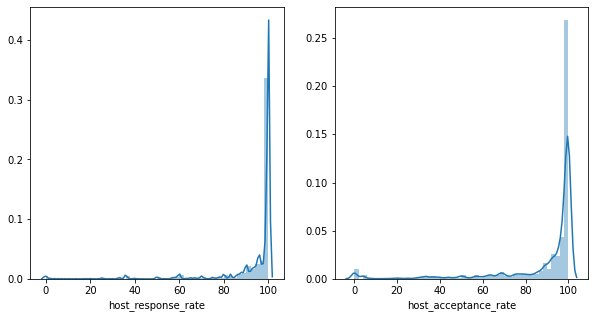

In [173]:
fig, ax = plt.subplots(1,2, figsize=(10, 5))

sns.distplot(listings['host_response_rate'], ax=ax[0])
sns.distplot(listings['host_acceptance_rate'], ax=ax[1])

fig.show()

Distribution after imputation. As we can see we have not significantly changed the distribution, that's good


<ipython-input-190-f6f34b440700>:6: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


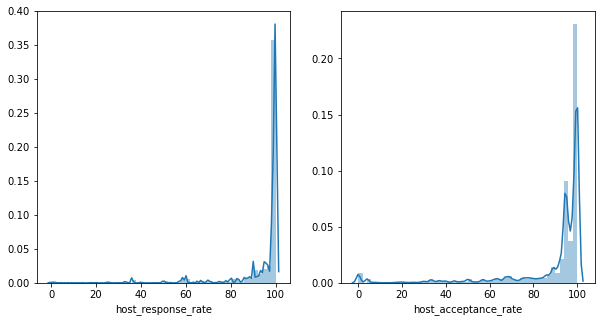

In [190]:
fig, ax = plt.subplots(1,2, figsize=(10, 5))

sns.distplot(listings['host_response_rate'], ax=ax[0])
sns.distplot(listings['host_acceptance_rate'], ax=ax[1])

fig.show()

#### host_is_superhost
As we may see there are several binary features listed below with 't'/'f' values, so we may convert them to numerical
- host_is_superhost
- host_has_profile_pic
- host_identity_verified
- has_availability
- instant_bookable

In [524]:
listings.head()

name  \
0                          Habitación muy acogedora.   
1       Cozy terrace apartment Apartamento con patio   
2  Apart. full equipped. 2 min to Subway lines L1...   
3    Huge flat for 8 people close to Sagrada Familia   
4                                  8 lacus, VICTORIA   

                                         description  \
0  Abrace la simplicidad en este lugar tranquilo ...   
1  A private terraced + 2 bedroom ground floor ap...   
2  Precioso apartamento ideal para parejas. Lumin...   
3  110m2 apartment to rent in Barcelona. Located ...   
4  8 apartaments que pretenen recordar la importà...   

                               neighborhood_overview  host_response_rate  \
0  El barrio es tranquilo y bien hubicado.   Cerc...               100.0   
1  The neighbourhood is quiet with trees. Though ...               100.0   
2  La zona dispone de servicios básicos y una exc...               100.0   
3  Apartment in Barcelona located in the heart of...                98.0   
4                                                NaN               100.0   

   host_acceptance_rate  host_is_superhost  host_total_listings_count  \
0                 100.0                0.0                        1.0   
1                 100.0                1.0                        1.0   
2                  97.0                1.0                        2.0   
3                  93.0                0.0                       42.0   
4                 100.0                1.0                        8.0   

   host_has_profile_pic  host_identity_verified neighbourhood_group_cleansed  \
0                   1.0                     1.0               Sants-Montjuïc   
1                   1.0                     1.0                    Les Corts   
2                   1.0                     1.0               Sants-Montjuïc   
3                   1.0                     1.0                     Eixample   
4                   1.0                     1.0               Sants-Montjuïc   

    latitude  longitude property_type  accommodates  bathrooms_text  bedrooms  \
0  41.363004   2.125326          room             2             1.0       2.0   
1  41.372630   2.113180   entire unit             5             1.0       2.0   
2  41.366400   2.116860   entire unit             2             1.0       1.0   
3  41.405560   2.172620   entire unit             8             2.0       3.0   
4  41.371880   2.122200   entire unit             2             1.0       1.0   

   beds  price  minimum_nights  maximum_nights  minimum_minimum_nights  \
0   2.0   59.0               1            1125                     1.0   
1   4.0  110.0               3              30                     3.0   
2   1.0   86.0               3              10                     3.0   
3   6.0  180.0               1            1125                     1.0   
4   1.0  110.0               2             365                     2.0   

   maximum_minimum_nights  minimum_maximum_nights  maximum_maximum_nights  \
0                     1.0                  1125.0                  1125.0   
1                     3.0                  1125.0                  1125.0   
2                     3.0                    10.0                    10.0   
3                     3.0                  1125.0                  1125.0   
4                     2.0                   365.0                   365.0   

   minimum_nights_avg_ntm  maximum_nights_avg_ntm  has_availability  \
0                     1.0                  1125.0                 1   
1                     3.0                  1125.0                 1   
2                     3.0                    10.0                 1   
3                     1.6                  1125.0                 1   
4                     2.0                   365.0                 1   

   availability_30  availability_60  availability_90  availability_365  \
0               18               48               78               351   
1                5         

In [15]:
listings.replace({'f': 0, 't': 1}, inplace=True)

In [16]:
print(f'{listings["host_is_superhost"].isna().sum()} missing values')
#impute with mode
listings['host_is_superhost'] = listings["host_is_superhost"].fillna(listings['host_is_superhost'].mode()[0])

2 missing values


In [17]:
#Applying nlp to these columns would lead to having too much features that may cause dimensionality problem
listings.drop(['name', 'description', 'neighborhood_overview'], axis = 1, inplace = True)

#### neighboorhoods
Lets keep just neighboorhood group cleansed, we do not want to create each of 73 features for neighboorhoods

In [216]:
listings.neighbourhood_cleansed.nunique(), listings.neighbourhood_group_cleansed.nunique()

(73, 10)

In [220]:
listings.neighbourhood_group_cleansed.isna().sum()

0

#### host_listings_count           

In [223]:
listings.host_listings_count.describe()

count    16918.000000
mean        28.257004
std         62.670485
min          1.000000
25%          1.000000
50%          5.000000
75%         23.000000
max        810.000000
Name: host_listings_count, dtype: float64

In [224]:
listings.host_total_listings_count.describe()

count    16918.000000
mean       163.317236
std       1468.452194
min          1.000000
25%          2.000000
50%          7.000000
75%         34.000000
max      20000.000000
Name: host_total_listings_count, dtype: float64

In [18]:
listings['host_total_listings_count'].fillna(listings['host_total_listings_count'].median(), inplace = True)
listings['host_listings_count'].fillna(listings['host_listings_count'].median(), inplace = True)

According to the data dictionary both features represent the same info, so lets drop one of them, the one that has lower correlation with target col.

In [266]:
listings.corr()['price'].sort_values( ascending = False)

price                                           1.000000
minimum_nights                                  0.138450
minimum_minimum_nights                          0.133743
minimum_nights_avg_ntm                          0.091947
bedrooms                                        0.088463
maximum_minimum_nights                          0.086248
host_total_listings_count                       0.081671
availability_30                                 0.075984
accommodates                                    0.074994
beds                                            0.070525
availability_60                                 0.067413
availability_90                                 0.061074
calculated_host_listings_count                  0.028495
instant_bookable                                0.028215
availability_365                                0.027201
maximum_nights                                  0.027083
host_listings_count                             0.022681
calculated_host_listings_count_

#### Host verifications

In [295]:
listings.host_verifications.value_counts()

['email', 'phone']                  13182
['email', 'phone', 'work_email']     2278
['phone']                            1008
['phone', 'work_email']               394
['email']                              49
[]                                      6
None                                    2
['work_email']                          1
Name: host_verifications, dtype: int64

In [269]:
#no missing 
listings.host_verifications.isna().sum()

0

We may create seperate features for email and phone

In [19]:
listings.loc[listings['host_verifications'].str.contains('phone'), 'verif_phone'] = 1
listings.loc[listings['host_verifications'].str.contains('email'), 'verif_email'] = 1

listings[['verif_phone', 'verif_email']] = listings[['verif_phone', 'verif_email']].fillna(0)

In [294]:
#Lets what we've got
listings['verif_phone'].value_counts(), listings['verif_email'].value_counts()

(1.0    16862
 0.0       58
 Name: verif_phone, dtype: int64,
 1.0    15904
 0.0     1016
 Name: verif_email, dtype: int64)

#### host_has_profile_pic	
#### host_identity_verified	

listings.corr()['price']

In [300]:
listings.host_has_profile_pic.value_counts()

1.0    16811
0.0      107
Name: host_has_profile_pic, dtype: int64

In [301]:
listings.host_identity_verified.value_counts()

1.0    14562
0.0     2356
Name: host_identity_verified, dtype: int64

In [20]:
listings[['host_has_profile_pic', 'host_identity_verified']] = listings[['host_has_profile_pic', 'host_identity_verified']].fillna(1).values

#### neighbourhood, neighbourhood_cleansed


In [319]:
#As soon as we are working on Barcelona dataset, there is no need to keep neighbourhood columns,but keep "neighbourhood group cleansed"
pd.set_option('display.max_rows', 50)

listings.neighbourhood

0        L'Hospitalet de Llobregat, Catalunya, Spain
1        L'Hospitalet de Llobregat, Catalunya, Spain
2        L'Hospitalet de Llobregat, Catalunya, Spain
3                               Barcelona, CT, Spain
4                                                NaN
                            ...                     
16915    L'Hospitalet de Llobregat, Catalunya, Spain
16916    L'Hospitalet de Llobregat, Catalunya, Spain
16917    L'Hospitalet de Llobregat, Catalunya, Spain
16918       Esplugues de Llobregat, Catalunya, Spain
16919                                            NaN
Name: neighbourhood, Length: 16920, dtype: object

In [322]:
listings.neighbourhood_cleansed.unique()

array(['Sants-Montjuïc', 'Les Corts', 'Eixample', 'Sant Martí', 'Gràcia',
       'Ciutat Vella', 'Sant Andreu', 'Sarrià-Sant Gervasi',
       'Horta-Guinardó', 'Nou Barris'], dtype=object)

#### Property type

There are 64 property types and lots of them has just a few or one value, so we may bin this feature into bigger categories.
Let's say we have just apartment or a house

In [473]:
#deepcopy just in case
df = listings.copy()

In [371]:
 listings.property_type.unique()

array(['Private room in condo', 'Entire condo', 'Entire rental unit',
       'Private room in rental unit', 'Entire loft',
       'Private room in home', 'Entire guesthouse',
       'Entire serviced apartment', 'Private room in bed and breakfast',
       'Entire villa', 'Entire townhouse', 'Entire home', 'Boat',
       'Private room in loft', 'Entire guest suite',
       'Private room in floor', 'Private room in serviced apartment',
       'Room in serviced apartment', 'Private room in vacation home',
       'Private room in guesthouse', 'Tiny home',
       'Shared room in rental unit', 'Private room in casa particular',
       'Shared room in bed and breakfast', 'Private room in guest suite',
       'Room in aparthotel', 'Shared room in hostel', 'Private room',
       'Room in boutique hotel', 'Shared room in home', 'Entire place',
       'Shared room in loft', 'Private room in hostel', 'Barn',
       'Private room in townhouse', 'Private room in boat',
       'Private room in chalet'

In [328]:
listings.property_type.value_counts()

Entire rental unit                    8369
Private room in rental unit           4788
Entire serviced apartment              498
Entire condo                           436
Room in hotel                          376
Entire loft                            327
Private room in condo                  288
Room in boutique hotel                 252
Private room in hostel                 215
Private room in home                   210
Private room in bed and breakfast      108
Private room in casa particular        105
Boat                                    98
Shared room in hostel                   90
Entire home                             89
Private room in guest suite             61
Private room in serviced apartment      54
Entire guest suite                      51
Entire guesthouse                       47
Private room in loft                    46
Shared room in rental unit              44
Room in hostel                          40
Entire villa                            32
Room in ser

In [21]:
rooms = [i for i in listings.property_type.unique() if 'room' in i.lower()]
entire = [i for i in listings.property_type.unique() if 'entire' in i.lower()]

In [342]:
listings.head()

name  \
0                          Habitación muy acogedora.   
1       Cozy terrace apartment Apartamento con patio   
2  Apart. full equipped. 2 min to Subway lines L1...   
3    Huge flat for 8 people close to Sagrada Familia   
4                                  8 lacus, VICTORIA   

                                         description  \
0  Abrace la simplicidad en este lugar tranquilo ...   
1  A private terraced + 2 bedroom ground floor ap...   
2  Precioso apartamento ideal para parejas. Lumin...   
3  110m2 apartment to rent in Barcelona. Located ...   
4  8 apartaments que pretenen recordar la importà...   

                               neighborhood_overview         host_name  \
0  El barrio es tranquilo y bien hubicado.   Cerc...  Maria Das Merces   
1  The neighbourhood is quiet with trees. Though ...             Nuria   
2  La zona dispone de servicios básicos y una exc...              Pepa   
3  Apartment in Barcelona located in the heart of...  Mireia And Maria   
4                                                NaN             Maria   

  host_since     host_location  \
0 2015-12-15               NaN   
1 2018-07-08  Barcelona, Spain   
2 2017-02-01               NaN   
3 2010-01-19  Barcelona, Spain   
4 2022-01-31               NaN   

                                          host_about  host_response_time  \
0  Sou Bailarina y Terapeuta Integrativa. Trabalh...      within an hour   
1  I live in Barcelona. I love travelling and mee...      within an hour   
2                                                NaN  within a few hours   
3  We are Mireia (43) & Maria (45), two multiling...      within an hour   
4                                                NaN      within an hour   

   host_response_rate  host_acceptance_rate  host_is_superhost  \
0               100.0                 100.0                0.0   
1               100.0                 100.0                1.0   
2               100.0                  97.0                1.0   
3                98.0                  93.0                0.0   
4               100.0                 100.0                1.0   

   host_neighbourhood  host_listings_count  host_total_listings_count  \
0                 NaN                  1.0                        1.0   
1                 NaN                  1.0                        1.0   
2                 NaN                  1.0                        2.0   
3  la Sagrada Família                 40.0                       42.0   
4                 NaN                  8.0                        8.0   

   host_verifications  host_has_profile_pic  host_identity_verified  \
0  ['email', 'phone']                   1.0                     1.0   
1  ['email', 'phone']                   1.0                     1.0   
2  ['email', 'phone']                   1.0                     1.0   
3  ['email', 'phone']                   1.0                     1.0   
4           ['phone']                   1.0                     1.0   

                                 neighbourhood      neighbourhood_cleansed  \
0  L'Hospitalet de Llobregat, Catalunya, Spain                  la Bordeta   
1  L'Hospitalet de Llobregat, Catalunya, Spain  la Maternitat i Sant Ramon   
2  L'Hospitalet de Llobregat, Catalunya, Spain               Sants - Badal   
3                         Barcelona, CT, Spain          la Sagrada Família   
4                                          NaN               Sants - Badal   

  neighbourhood_group_cleansed   latitude  longitude          property_type  \
0               Sants-Montjuïc  41.363004   2.125326  Private room in condo   
1                    Les Corts  41.372630   2.113180           Entire condo   
2               Sants-Montjuïc  41.366400   2.116860     Entire rental unit   
3                     Eixample  41.405560   2.172620     Entire rental unit   
4               Sants-Montjuïc  41.371880   2.122200     Entire rental unit   

         room_type  accommodates bathrooms_text  bedrooms  b

In [22]:
#lets bin into 3 categories: room, entire unit, others

for i in rooms:
    listings.property_type = listings.property_type.replace({i: 'room'})

for x in entire:
     listings.property_type = listings.property_type.replace({x: 'entire unit'})
        
listings.loc[~listings.property_type.isin(['room', 'entire unit']), 'property_type'] = 'others'

In [378]:
listings.property_type.value_counts()

entire unit    9913
room           6884
others          123
Name: property_type, dtype: int64

#### Room Type
We may drop this feature as soon as we have property type

In [381]:
listings.room_type.value_counts()

Entire home/apt    10046
Private room        6526
Shared room          176
Hotel room           172
Name: room_type, dtype: int64

#### bathrooms_text

In [23]:
p = '[\d]+[.,\d]+|[\d]*[.][\d]+|[\d]+'

#extract digits from the column
listings.bathrooms_text = listings.bathrooms_text.apply(lambda x: re.findall(p, str(x)))
listings.bathrooms_text = listings.bathrooms_text.apply(lambda x: str(x)[1:]).str[:-1].values
listings.bathrooms_text = listings.bathrooms_text.str.replace("'", "").replace('', np.nan).values
listings.bathrooms_text = listings.bathrooms_text.astype('float64')

In [24]:
#impute the following three features
for col in ['bathrooms_text', 'bedrooms', 'beds']:
    listings[col].fillna(listings[col].median(), inplace=True)

#### amenities
At first we have to identify key amenities. That could be done using text processing + airbnb web articles

In [25]:
#text cleansing function
def clean_text(text):
    text= text.lower()
    #remove digits
    text= re.sub('[0-9]', '', text)
    #remove punctuation
    text  = "".join([char for char in text if char not in string.punctuation])
    #tokenizing
    tokens = word_tokenize(text)
    #tokens = [lemmatizer.lemmatize(w) for w in tokens]
    #remove stopwords
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    tokens = [word for word in tokens if word not in stopwords.words('spanish')]
    text = ' '.join(tokens)
    return text

In [27]:
#cleaned amenities
listings['amenities_cl'] = listings['amenities'].apply(lambda x: clean_text(x)).values

In [481]:
#extract most common words from the text corpus
corpus_cl = listings.amenities_cl.apply(lambda x: [word.lower() for word in x.split()])
cnt_cl = Counter()
for x in corpus_cl:
    cnt_cl.update(x)
print(cnt_cl.most_common(100))

[('allowed', 19581), ('dryer', 17709), ('wifi', 17413), ('long', 15556), ('term', 15556), ('stays', 15556), ('essentials', 15419), ('hot', 15253), ('water', 15001), ('kitchen', 14941), ('tv', 13881), ('washer', 13475), ('hair', 13196), ('heating', 13048), ('hangers', 13008), ('iron', 12429), ('dishes', 11047), ('silverware', 11047), ('refrigerator', 10946), ('air', 10879), ('conditioning', 10878), ('coffee', 10219), ('maker', 10156), ('bed', 9762), ('linens', 9761), ('cooking', 9611), ('basics', 9611), ('microwave', 9556), ('elevator', 9325), ('shampoo', 9136), ('parking', 9008), ('oven', 8065), ('clothing', 7753), ('paid', 7632), ('alarm', 7617), ('premises', 7585), ('stove', 7223), ('balcony', 6934), ('patio', 6933), ('crib', 6527), ('private', 5909), ('free', 5789), ('dishwasher', 5232), ('dedicated', 5183), ('workspace', 5183), ('dining', 4900), ('pillows', 4823), ('extra', 4822), ('blankets', 4822), ('u', 4667), ('host', 4557), ('greets', 4557), ('smoke', 4543), ('shower', 4498), 

In [ ]:
listings.loc[listings['amenities_cl'].str.contains('kitchen'), 'has_kitchen'] = 1
listings.loc[listings['amenities_cl'].str.contains('conditioning'), 'has_conditioning'] = 1
listings.loc[listings['amenities_cl'].str.contains('amazon|apple|game console|netflix|projector|smart tv|sony|hbo'), 'has_smart_perks'] = 1
listings.loc[listings['amenities_cl'].str.contains('workspace'), 'has_workspace'] = 1
listings.loc[listings['amenities_cl'].str.contains('free parking'), 'parking'] = 1
listings.loc[listings['amenities_cl'].str.contains('balcony|patio'), 'balcony'] = 1
listings.loc[listings['amenities_cl'].str.contains('beach|lake|mountain|ski in|ski out|waterfront'), 'has_views'] = 1
listings.loc[listings['amenities_cl'].str.contains('washer|dryer|dishwasher'), 'has_washer'] = 1
listings.loc[listings['amenities_cl'].str.contains('tv'), 'has_tv'] = 1
listings.loc[listings['amenities_cl'].str.contains('elevator'), 'has_elevator'] = 1
listings.loc[listings['amenities_cl'].str.contains('garden|outdoor|sun loungers|terrace'), 'outdoor_space'] = 1
listings.loc[listings['amenities_cl'].str.contains('internet|wifi'), 'has_inet'] = 1
listings.loc[listings['amenities_cl'].str.contains('pets|pet|cat|dog'), 'pets_allowed'] = 1
listings.loc[listings['amenities_cl'].str.contains('self check'), 'has_self_checkin'] = 1

In [ ]:
#fill nans with 0s
new_cols = listings.iloc[:, -14:].columns
listings[new_cols] = listings[new_cols].fillna(0)

In [501]:
#extract columns that has less or equal than 1 unique value i.e 0 unique values - 100% missing, 1 unique - no sense for modelling
temp_drop = listings.nunique()[listings.nunique() <= 1].index
listings.nunique()[listings.nunique() <= 1]

Series([], dtype: int64)

In [517]:
for x in new_cols:
    print(listings[x].value_counts())

1.0    14942
0.0     1978
Name: has_kitchen, dtype: int64
1.0    10871
0.0     6049
Name: has_conditioning, dtype: int64
0.0    16052
1.0      868
Name: has_smart_perks, dtype: int64
0.0    11737
1.0     5183
Name: has_workspace, dtype: int64
0.0    16222
1.0      698
Name: parking, dtype: int64
0.0    15752
1.0     1168
Name: has_views, dtype: int64
1.0    15904
0.0     1016
Name: has_washer, dtype: int64
1.0    13214
0.0     3706
Name: has_tv, dtype: int64
1.0    9325
0.0    7595
Name: has_elevator, dtype: int64
0.0    14777
1.0     2143
Name: outdoor_space, dtype: int64
1.0    16476
0.0      444
Name: has_inet, dtype: int64
0.0    11709
1.0     5211
Name: pets_allowed, dtype: int64
0.0    9986
1.0    6934
Name: balcony, dtype: int64
0.0    16859
1.0       61
Name: has_self_checkin, dtype: int64


In [518]:
#The last value has too few values for check_in to include it for feature set
listings.drop('has_self_checkin', axis = 1, inplace = True)

In [521]:
#We may drop then now
listings.drop(['amenities', 'amenities_cl'], axis = 1, inplace = True)

#### Max and min nights

In [537]:
listings.corr()['price'].sort_values(ascending = True)

host_response_rate                             -0.043026
has_kitchen                                    -0.034178
review_scores_rating                           -0.031821
review_scores_accuracy                         -0.024151
has_workspace                                  -0.022794
pets_allowed                                   -0.022508
review_scores_location                         -0.020720
longitude                                      -0.011327
review_scores_checkin                          -0.009480
host_acceptance_rate                           -0.009306
host_exp                                       -0.008839
number_of_reviews_l30d                         -0.008703
reviews_per_month                              -0.008658
has_views                                      -0.008650
outdoor_space                                  -0.007125
calculated_host_listings_count_shared_rooms    -0.006881
latitude                                       -0.006298
has_smart_perks                

In [556]:
#we leave night features that highly correlated with price
nights_cols = [x for x in listings.columns if 'night' in x]
print(nights_cols)

listings.drop(nights_cols[2:], axis = 1, inplace = True)

['minimum_nights', 'maximum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm']


#### reviews

In [559]:
pd.set_option('display.max_rows', 50)
listings['last_review']

0        2022-09-08
1        2022-08-26
2        2022-09-06
3        2022-08-29
4        2022-07-18
            ...    
16915    2019-12-27
16916    2019-02-17
16917    2020-02-19
16918    2022-07-29
16919    2022-06-13
Name: last_review, Length: 16920, dtype: object

In [565]:
listings.last_review = pd.to_datetime(listings.last_review)
listings.last_review

0       2022-09-08
1       2022-08-26
2       2022-09-06
3       2022-08-29
4       2022-07-18
           ...    
16915   2019-12-27
16916   2019-02-17
16917   2020-02-19
16918   2022-07-29
16919   2022-06-13
Name: last_review, Length: 16920, dtype: datetime64[ns]

In [585]:
listings['days_since_last_review'] = (source_date - listings.last_review).apply(lambda x: x.days).values
listings['days_since_last_review'] = listings['days_since_last_review'].fillna(listings['days_since_last_review'].median())

In [588]:
rev_cols = [col for col in listings.columns if 'review_score' in col]

['review_scores_rating',
 'review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_value']

In [590]:
listings.head()

host_response_rate  host_acceptance_rate  host_is_superhost  \
0               100.0                 100.0                0.0   
1               100.0                 100.0                1.0   
2               100.0                  97.0                1.0   
3                98.0                  93.0                0.0   
4               100.0                 100.0                1.0   

   host_total_listings_count  host_has_profile_pic  host_identity_verified  \
0                        1.0                   1.0                     1.0   
1                        1.0                   1.0                     1.0   
2                        2.0                   1.0                     1.0   
3                       42.0                   1.0                     1.0   
4                        8.0                   1.0                     1.0   

  neighbourhood_group_cleansed   latitude  longitude property_type  \
0               Sants-Montjuïc  41.363004   2.125326          room   
1                    Les Corts  41.372630   2.113180   entire unit   
2               Sants-Montjuïc  41.366400   2.116860   entire unit   
3                     Eixample  41.405560   2.172620   entire unit   
4               Sants-Montjuïc  41.371880   2.122200   entire unit   

   accommodates  bathrooms_text  bedrooms  beds  price  minimum_nights  \
0             2             1.0       2.0   2.0   59.0               1   
1             5             1.0       2.0   4.0  110.0               3   
2             2             1.0       1.0   1.0   86.0               3   
3             8             2.0       3.0   6.0  180.0               1   
4             2             1.0       1.0   1.0  110.0               2   

   maximum_nights  has_availability  availability_30  availability_60  \
0            1125                 1               18               48   
1              30                 1                5               25   
2              10                 1                2                2   
3            1125                 1               10               29   
4             365                 1                8               22   

   availability_90  availability_365  number_of_reviews  \
0               78               351                  9   
1               55               151                 54   
2               19               218                145   
3               39                60                 30   
4               52               106                 10   

   number_of_reviews_ltm  number_of_reviews_l30d first_review last_review  \
0                      9                       9   2022-08-11  2022-09-08   
1                     40                       4   2020-11-20  2022-08-26   
2                     34                       3   2017-03-01  2022-09-06   
3                      9                       3   2013-05-27  2022-08-29   
4                     10                       0   2022-02-25  2022-07-18   

   review_scores_rating  review_scores_accuracy  review_scores_cleanliness  \
0                  4.89                    4.89                       5.00   
1                  4.83                    4.89                       4.70   
2                  4.94                    4.97                       4.94   
3                  4.38                    4.48                       4.72   
4                  4.70                    5.00                       4.90   

   review_scores_checkin  review_scores_communication  review_scores_location  \
0                   5.00                         4.89                    4.89   
1                   5.00                         4.98                    4.52   
2                   4.99                         4.99                    4.70   
3                   4.83                         4.79                    4.79   
4                   4.70                         4.50                    4.40   

   review_scores_value  instant_bookable  calculated_host_

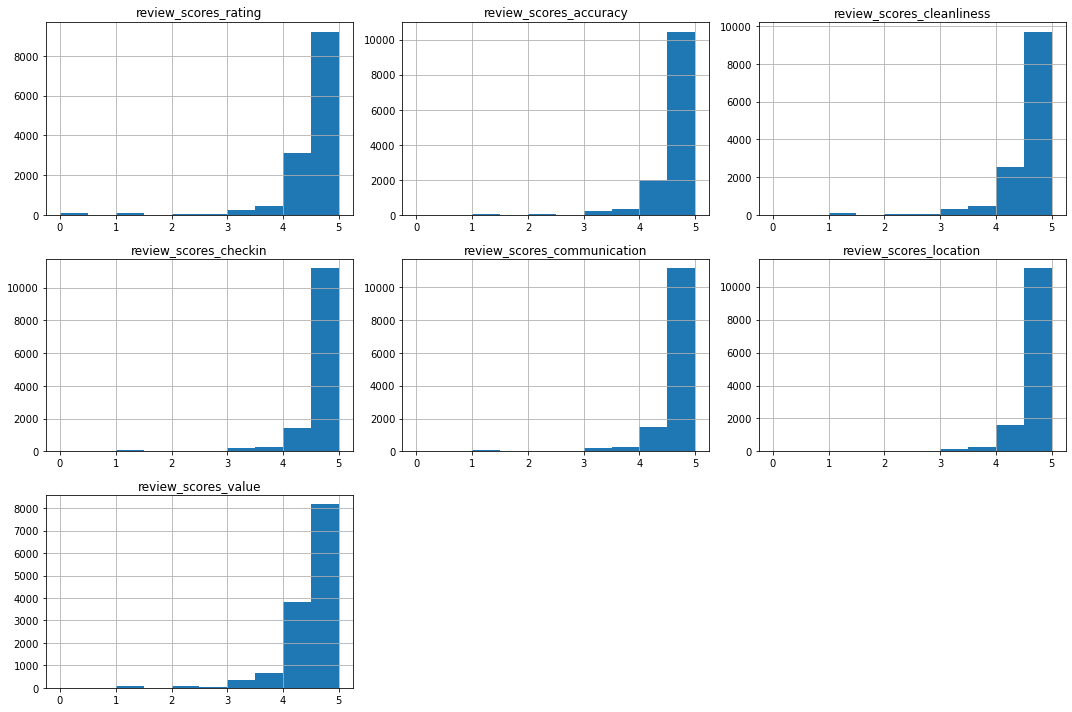

In [594]:
#For binning columns
rev_cols = [col for col in listings.columns if 'review_score' in col]
fig = plt.figure(figsize = (15, 10))
for i, col in enumerate(rev_cols):
    ax = fig.add_subplot(3,3,i+1)
    listings[col].hist(bins=10,ax=ax)
    ax.set_title(col)
fig.tight_layout()
plt.show()

We see that most of the data distributed above "3".

In [598]:
rev_cols

['review_scores_rating',
 'review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_value']

In [602]:
#There were some duplicates
listings.drop_duplicates(inplace = True)

Bin them to categories below 3, 3-4, 4-5 and others are missing 

In [640]:
bins = [0, 3, 4, 5]
labels = ['<3', '4', '5']
for col in rev_cols:
    listings[col] = pd.cut(listings[col].values, bins = bins, labels = labels, include_lowest = True)
    listings[col] = listings[col].astype('str')
    listings[col].fillna('nan', inplace=True)

In [643]:
#reviews per month may lead to multicollinearity, first and last review not needed as mentioned above
listings.drop(['first_review', 'last_review', 'reviews_per_month'], axis = 1, inplace = True)

In [459]:
#Drop the columns we decided to drop during the data preparation

to_drop  =  [
           'host_name', 'host_about', 'host_location', 
           'host_since', 'neighbourhood', 'neighbourhood_cleansed',
           'host_neighbourhood', 'host_listings_count', 'host_verifications',
           'neighbourhood', 'neighbourhood_cleansed', 'room_type',
            ]

listings.drop(to_drop, axis = 1, inplace = True)

Finallly no missing data

In [644]:
pd.set_option('display.max_rows', None)
listings.isna().sum()

host_response_rate                              0
host_acceptance_rate                            0
host_is_superhost                               0
host_total_listings_count                       0
host_has_profile_pic                            0
host_identity_verified                          0
neighbourhood_group_cleansed                    0
latitude                                        0
longitude                                       0
property_type                                   0
accommodates                                    0
bathrooms_text                                  0
bedrooms                                        0
beds                                            0
price                                           0
minimum_nights                                  0
maximum_nights                                  0
has_availability                                0
availability_30                                 0
availability_60                                 0


In [645]:
#Make sure each column in the right dtype
listings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16918 entries, 0 to 16919
Data columns (total 54 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   host_response_rate                            16918 non-null  float64
 1   host_acceptance_rate                          16918 non-null  float64
 2   host_is_superhost                             16918 non-null  float64
 3   host_total_listings_count                     16918 non-null  float64
 4   host_has_profile_pic                          16918 non-null  float64
 5   host_identity_verified                        16918 non-null  float64
 6   neighbourhood_group_cleansed                  16918 non-null  object 
 7   latitude                                      16918 non-null  float64
 8   longitude                                     16918 non-null  float64
 9   property_type                                 16918 non-null 

# EDA

### Target


 mu = 172.93 and sigma = 927.57



Text(0.5, 1.0, 'Price distribution')

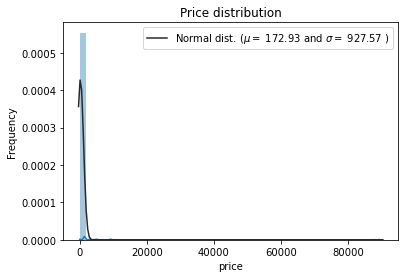

In [652]:
sns.distplot(listings['price'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(listings['price'])
#print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Price distribution')


We see that target variable is right skewed and has outliers

In [655]:
listings.price.describe()

count    16918.000000
mean       172.926587
std        927.599985
min          0.000000
25%         50.000000
50%        100.000000
75%        191.000000
max      90000.000000
Name: price, dtype: float64

In [660]:
q1 = np.percentile(listings.price, 25)
q3 = np.percentile(listings.price, 75)
iqr = q3 - q1
print(f'upper bound: {q3 + iqr}')

upper bound: 332.0


In [659]:
#prices above 332 are outliers, lets see whether they are natural
listings[listings.price > q3 + iqr].head(50)

host_response_rate  host_acceptance_rate  host_is_superhost  \
10           100.000000             98.000000                0.0   
43            96.000000             93.000000                0.0   
51           100.000000            100.000000                0.0   
76           100.000000             96.000000                1.0   
83            96.000000             98.000000                0.0   
93            94.000000             90.000000                0.0   
127           93.000000             96.000000                0.0   
129          100.000000             78.000000                0.0   
132          100.000000            100.000000                1.0   
155          100.000000             44.000000                0.0   
217           98.666667             94.666667                0.0   
227          100.000000             99.000000                1.0   
238          100.000000            100.000000                0.0   
245           93.000000             93.000000                0.0   
254          100.000000             44.000000                0.0   
282          100.000000             87.000000                1.0   
296          100.000000             96.000000                0.0   
298           97.000000             36.000000                0.0   
316          100.000000            100.000000                0.0   
334           78.000000             92.000000                0.0   
370          100.000000             89.000000                1.0   
422          100.000000             99.000000                0.0   
425          100.000000            100.000000                1.0   
439          100.000000            100.000000                1.0   
441           96.000000            100.000000                0.0   
448           96.000000            100.000000                0.0   
449          100.000000            100.000000                0.0   
483           94.000000             95.000000                0.0   
485           94.000000             95.000000                0.0   
490           94.000000            100.000000                0.0   
493          100.000000            100.000000                1.0   
498          100.000000            100.000000                0.0   
500          100.000000            100.000000                0.0   
504          100.000000            100.000000                0.0   
533          100.000000             89.000000                1.0   
555          100.000000            100.000000                1.0   
557          100.000000             87.000000                1.0   
571          100.000000            100.000000                1.0   
580           99.000000            100.000000                0.0   
581          100.000000            100.000000                0.0   
591           95.000000             94.000000                0.0   
604          100.000000             87.000000                1.0   
605          100.000000             99.000000                0.0   
606          100.000000             99.000000                0.0   
638          100.000000            100.000000                1.0   
660          100.000000             89.000000                1.0   
690          100.000000             99.000000                0.0   
693          100.000000             99.000000                0.0   
704          100.000000             87.000000                1.0   
756           95.000000             96.000000                0.0   

     host_total_listings_count  host_has_profile_pic  host_identity_verified  \
10                        11.0                   1.0                     1.0   
43                         9.0                   1.0                     1.0   
51                        16.0                   1.0                     1.0   
76                        11.0                   1.0                     1.0   
83                        31.0                   1.0                     1.0   
93                        19.0                   1.0    

Lets transform target variable to normal distr. 

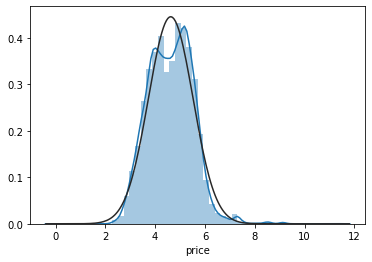

In [653]:
sns.distplot(np.log1p(listings['price']) , fit=norm);

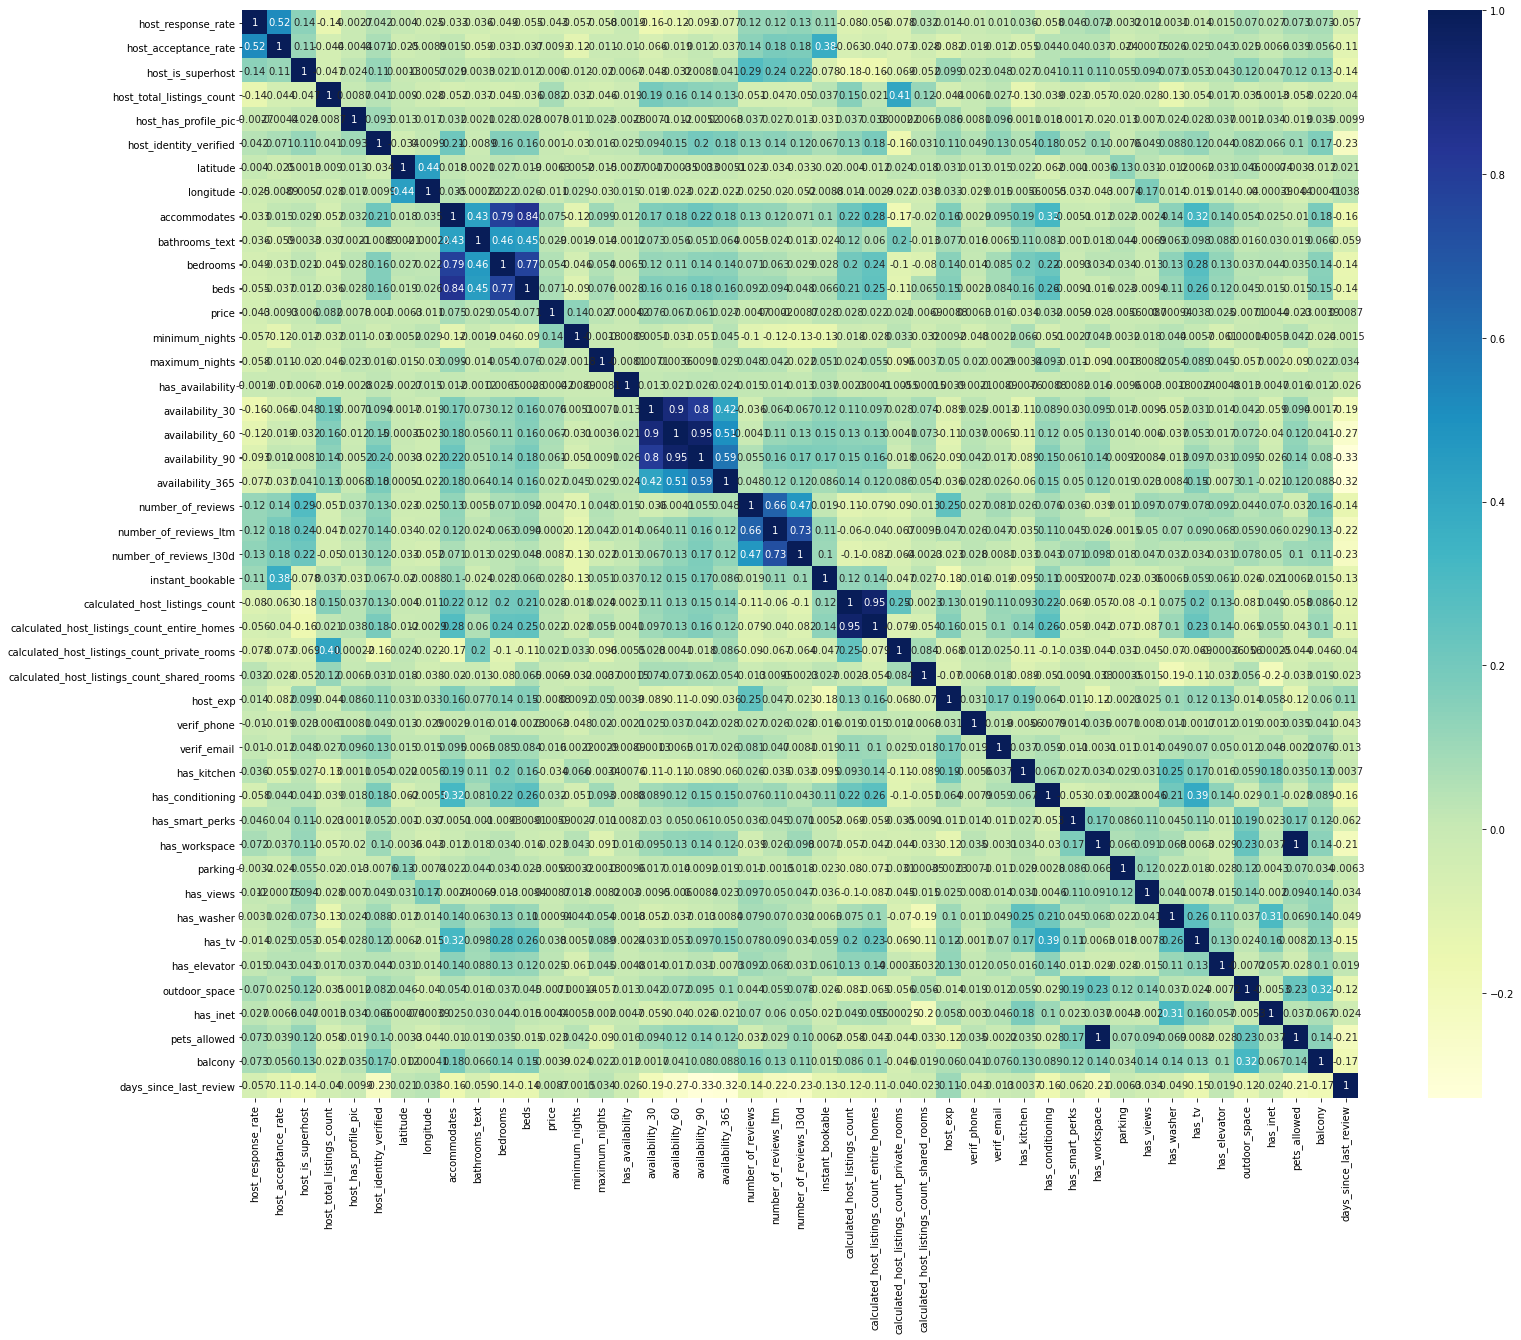

In [663]:
#Correlation heatmap
fig, ax = plt.subplots(figsize=(25 ,20)) 
sns.heatmap(listings.corr(), cmap="YlGnBu", annot = True)

### Multicollinearity problem

We see there are potential multicollinearity related to:
- bedrooms, beds, accomodates
- availability
- pets_allowed/hsa_workspace

Let's verify this by variance inflation score. vif > 5 tells us about multicollinearity

In [675]:
def vif(cols):
    vif = pd.DataFrame()
    
    vif["feature"] = cols
    
    vif["VIF"] = [variance_inflation_factor(listings[cols].values, i)
                          for i in range(len(cols))]
    
    return vif

In [676]:
vif(['bedrooms', 'accommodates', 'beds'])

feature        VIF
0      bedrooms   9.528042
1  accommodates  12.990705
2          beds  10.051854

Lets remove two features with lower correlation with target col

In [677]:
avail_cols = [col for col in listings.columns if 'availability' in col][1:]

vif(avail_cols)

feature        VIF
0   availability_30  11.292444
1   availability_60  53.349499
2   availability_90  36.123817
3  availability_365   3.754937

In [679]:
to_drop = [
           'bedrooms', 'accommodates', 
           'availability_60', 'availability_90',
           'number_of_reviews_l30d', 'number_of_reviews_l30d',
           'calculated_host_listings_count_entire_homes'
          ]

listings.drop(to_drop, axis = 1, inplace = True)

### Numerical features

In [691]:
numerical_cols = [col for col in listings.columns if 
                listings[col].dtype in ['int64', 'float64']]

#we do not want to consider binary features
numerical_cols = [col for col in numerical_cols if listings[col].nunique() > 2]
numerical_cols

['host_response_rate',
 'host_acceptance_rate',
 'host_total_listings_count',
 'latitude',
 'longitude',
 'bathrooms_text',
 'beds',
 'price',
 'minimum_nights',
 'maximum_nights',
 'availability_30',
 'availability_365',
 'number_of_reviews',
 'number_of_reviews_ltm',
 'calculated_host_listings_count',
 'calculated_host_listings_count_private_rooms',
 'calculated_host_listings_count_shared_rooms',
 'host_exp',
 'days_since_last_review']

In [694]:
len(numerical_cols)

19

C:\Users\ragec\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


IndexError: list index out of range

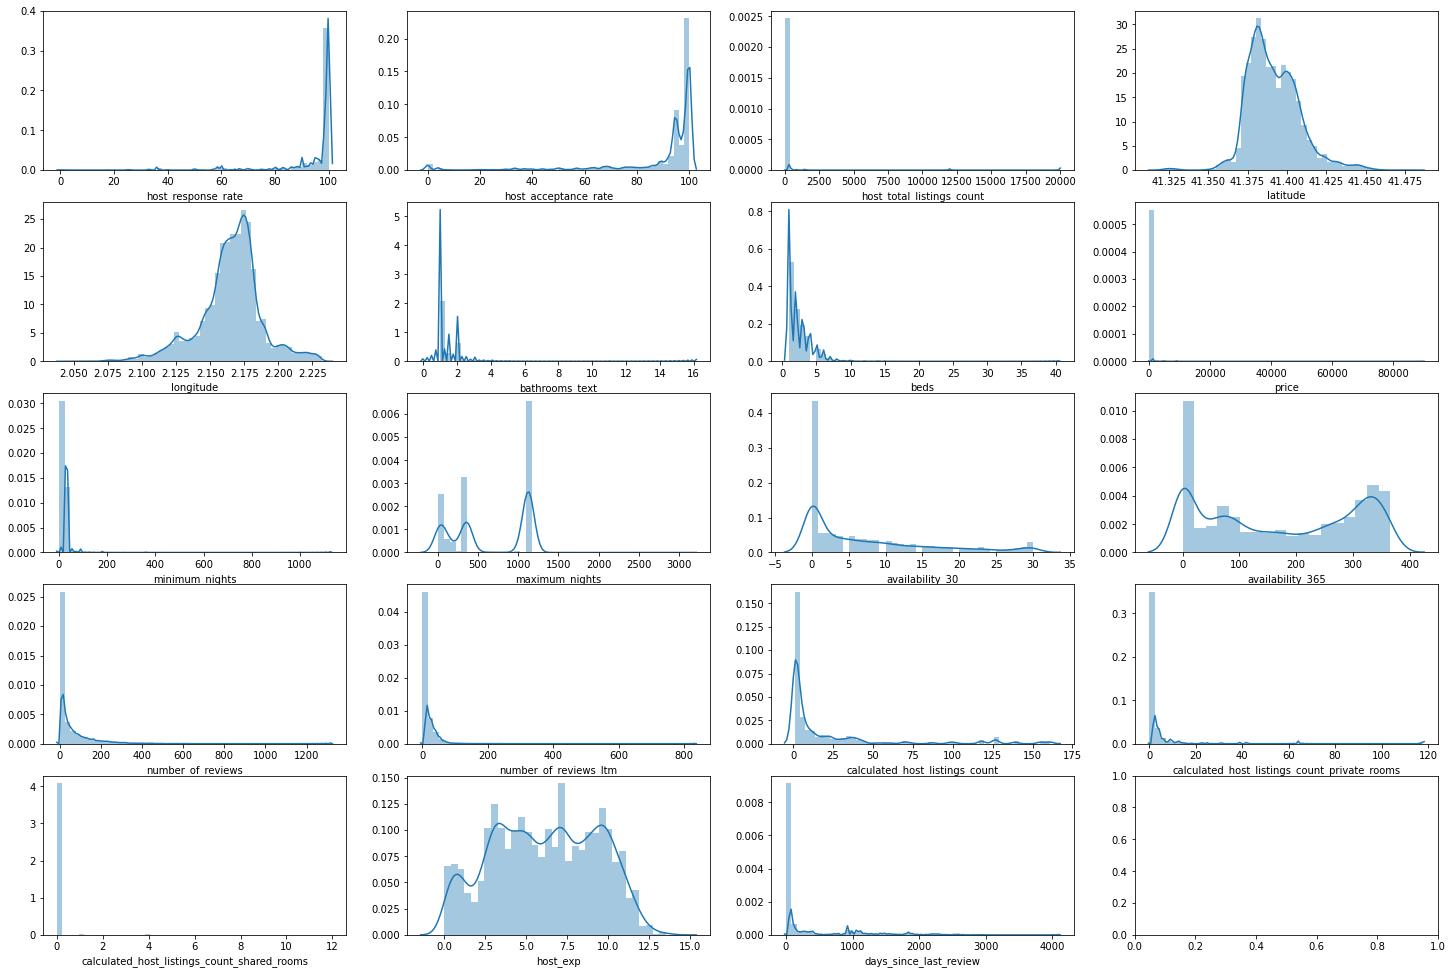

In [701]:
fig, axes = plt.subplots(nrows = 5, ncols = 4) 
i = 0
fig.set_figheight(17)
fig.set_figwidth(25)
for row in axes:
    for col in row:
        sns.distplot(listings[numerical_cols[i]], ax = col)
        i+=1
        
plt.tight_layout()

IndexError: list index out of range

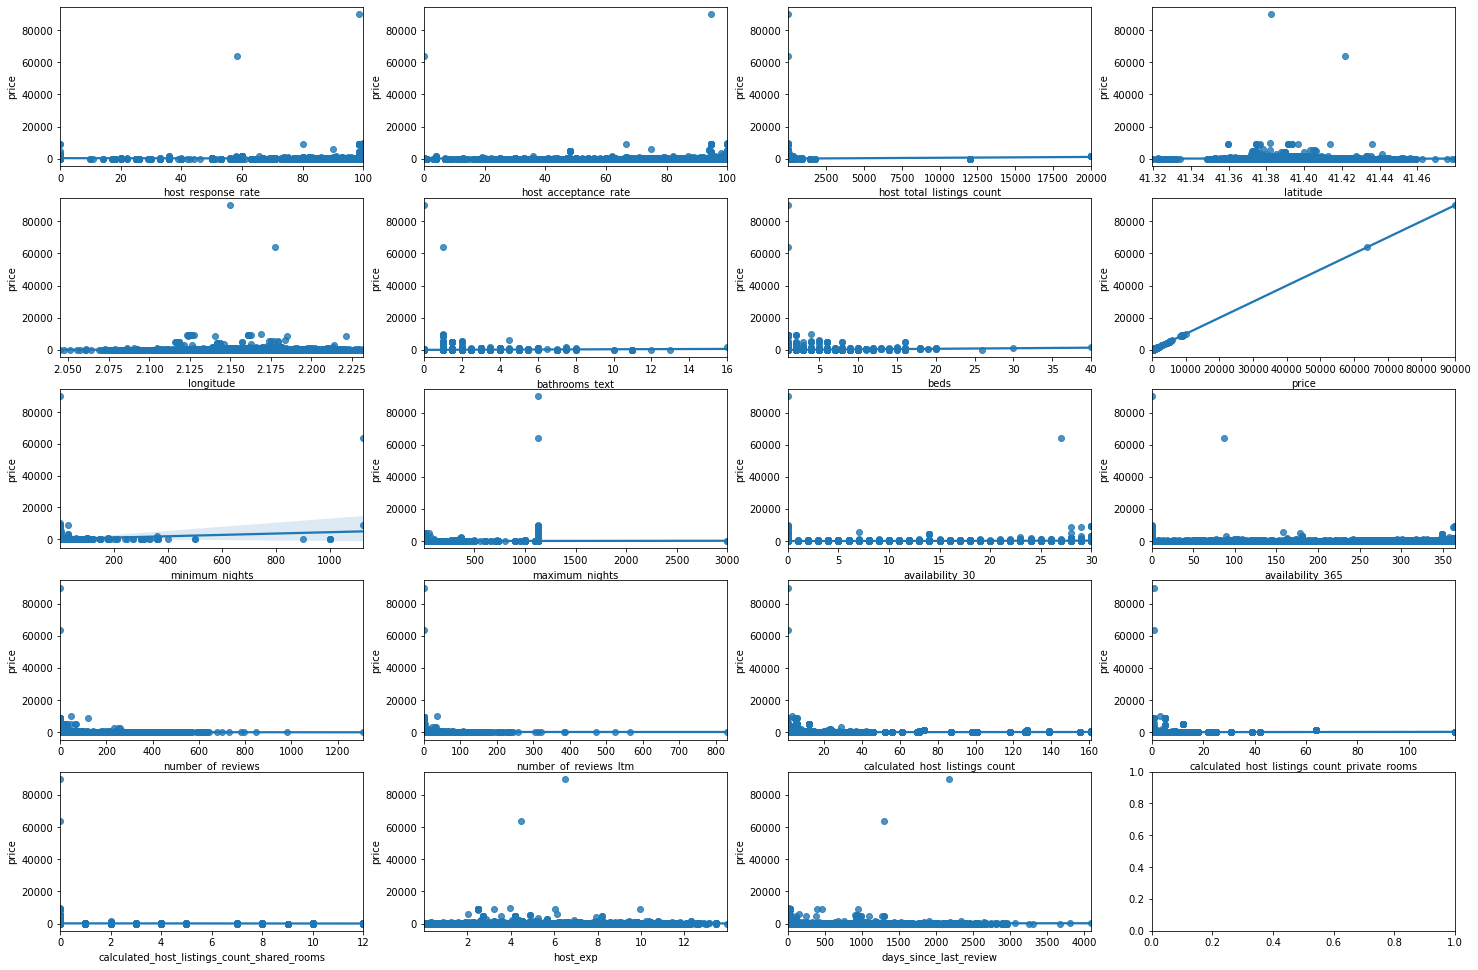

In [737]:
fig, axes = plt.subplots(nrows = 5, ncols = 4) 
i = 0
fig.set_figheight(17)
fig.set_figwidth(25)
for row in axes:
    for col in row:
        sns.regplot(x = numerical_cols[i], y = 'price', data = listings, ax = col)
        i+=1
        
plt.tight_layout()

Most of the numerical data is right skewed. There is no clear linear relationship between numerical cols and target

### Categorical

In [707]:
cat_cols = listings.select_dtypes('object').columns
cat_cols

Index(['neighbourhood_group_cleansed', 'property_type', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value'],
      dtype='object')

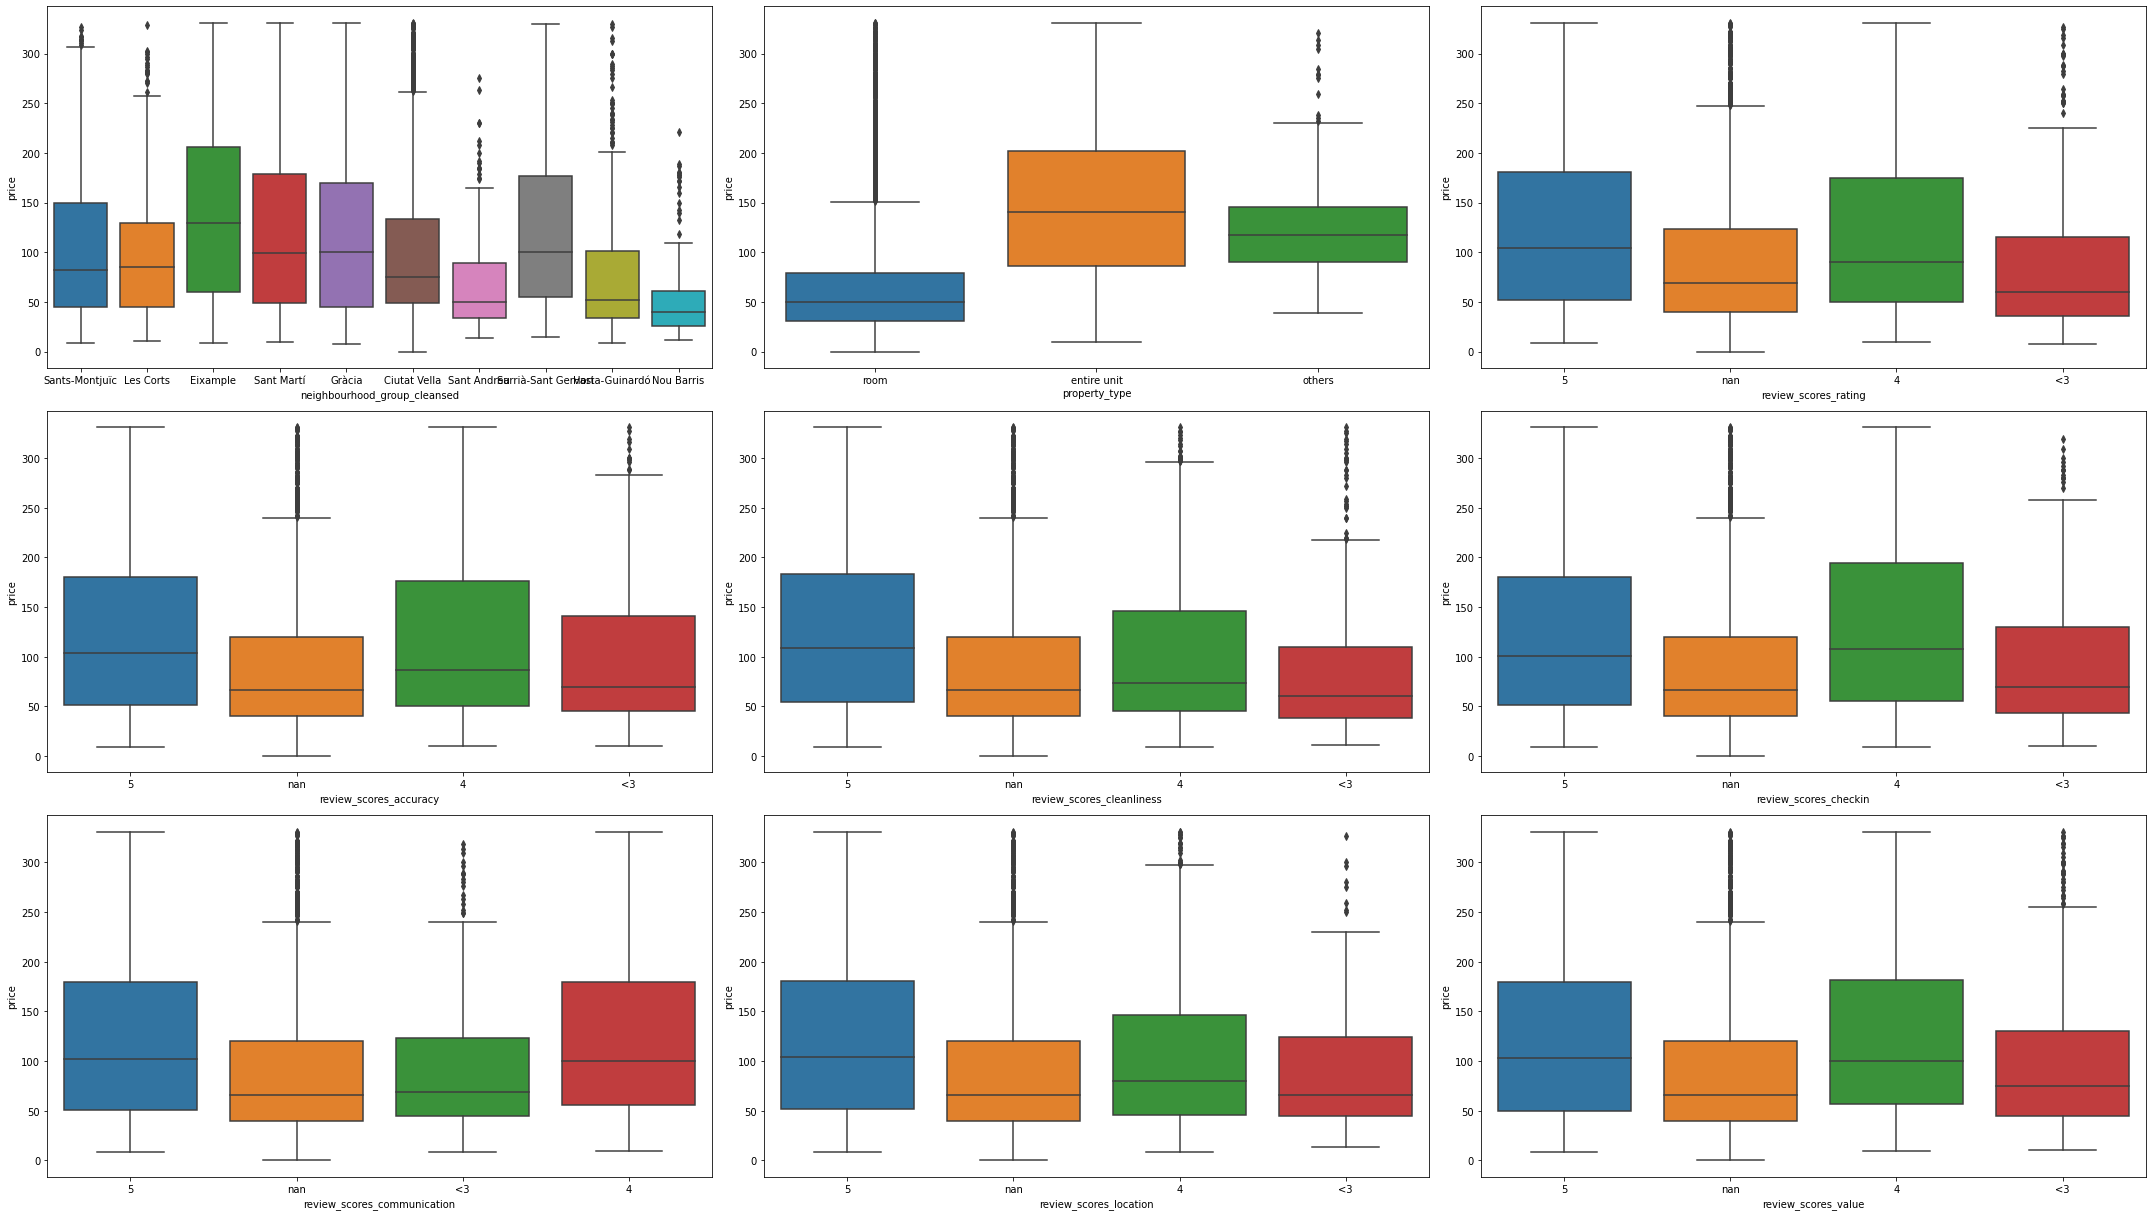

In [729]:
#observe categorical columns without outliers 
data = listings[listings.price < q3 + iqr]

fig, axes = plt.subplots(nrows = 3, ncols = 3) 
i = 0
fig.set_figheight(17)
fig.set_figwidth(30)
for row in axes:
    for col in row:
        sns.boxplot(x = cat_cols[i], y = 'price', data = data, ax = col)
        i+=1
        
plt.tight_layout()

- neighbourhood: We see that some neighbourhoods have clearly higher median price, thats related to location (it will be researched further)
- property type: Entire units have higher prices
- reviews: obviously higher review score, higher prices

### Geo

In [5]:
fig = px.scatter(listings, x = 'longitude', y = 'latitude',
                 color='neighbourhood_group_cleansed') 
fig.update_layout( xaxis_title = "longitude", yaxis_title = "latitude")
fig.show()

HTML(fig.to_html())

#### Lets generate new feature, distance to the center of Barcelona

Plaça de Catalunya, or Catalonia Square, is the central and one of the largest squares of Barcelona, Spain.

In [746]:
def center_dist(lat, long):
    barcelona_center = (41.387016, 2.170047)
    x = (lat, long)
    return great_circle(barcelona_center, x).km

In [749]:
listings['distance_center'] = listings.apply(lambda x: center_dist(x.latitude, x.longitude), axis = 1)

### Modelling

In [757]:
y = listings.price
X = listings.drop('price', axis = 1)
rs = 101

In [782]:
#Categorical encoding
dummies = pd.get_dummies(listings[cat_cols])

In [783]:
X = X.drop(cat_cols, axis = 1).join(dummies).copy()

In [810]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state  = rs, shuffle = True) 

### Naive Model
Naive model is used to have something we can rely on in terms of the the ML models performance. Lets pick up median price
- MAPE metric has been selected, as percentage equivalent to mae. Metric is better in terms of interpretability, especially for the management board
    - Lower the MAPE, more accurate the prediction
    - <10% - very good
    - 10-20% - Good
    - 20-50% - OK
    - Higher 50%   - Not good
- Additionally RMSE would be used for model comparison which shows how distant predicted values from the actual

In [767]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

In [818]:
def metrics(y_true, y_pred):
    mape = np.mean(np.abs((y_pred-y_true)/y_true))
    rmse = round(np.sqrt(mean_squared_error(y_true, y_pred)),4)
    print(f"MAPE : {(mape)*100:0.2f}%")
    print(f"RMSE : {rmse}")

Model is outputing the median price according to the property type

In [808]:
#tmp_naive = listings.copy()
#_, X_test, _, _ = train_test_split(tmp_naive, y, test_size = 0.2, random_state  = rs, shuffle = True) 

predicted = X_test['property_type'].map(listings.groupby('property_type')['price'].median())
print(f"MAPE: {(mape(y_test, predicted))*100:0.2f}%")

MAPE: 65.37%


In [802]:
print("\nRMSE:", round(np.sqrt(mean_squared_error(y_test, predicted)),4))


RMSE: 317.9384


#### Normalization and Categorical encoding

In [814]:
#Normalization
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

### Linear Regression

In order to handle skewness, we log-transform target variable. This technique would be used for each ml model

In [798]:
lr = LinearRegression()

lr.fit(X_train, np.log1p(y_train))
y_pred = lr.predict(X_test)

In [803]:
metrics(y_test, np.expm1(y_pred))

MAPE accuracy: 48.49%
RMSE : 291.9336


### Tree based algorithms
#### Random Forest

In [804]:
rf = RandomForestRegressor()

rf.fit(X_train, np.log1p(y_train))
y_pred = rf.predict(X_test)

In [805]:
metrics(y_test, np.expm1(y_pred))

MAPE accuracy: 30.11%
RMSE : 258.4202


As we may see result are getting better

In [815]:
xg_reg = xgb.XGBRegressor(objective='reg:squarederror')
xg_reg.fit(X_train, np.log1p(y_train))
y_pred = xg_reg.predict(X_test)

In [816]:
#Slightly better results
metrics(y_test, np.expm1(y_pred))

MAPE accuracy: 30.09%
RMSE : 252.2629


### Feature importance

Text(0.5, 1.0, 'Feature Importance')

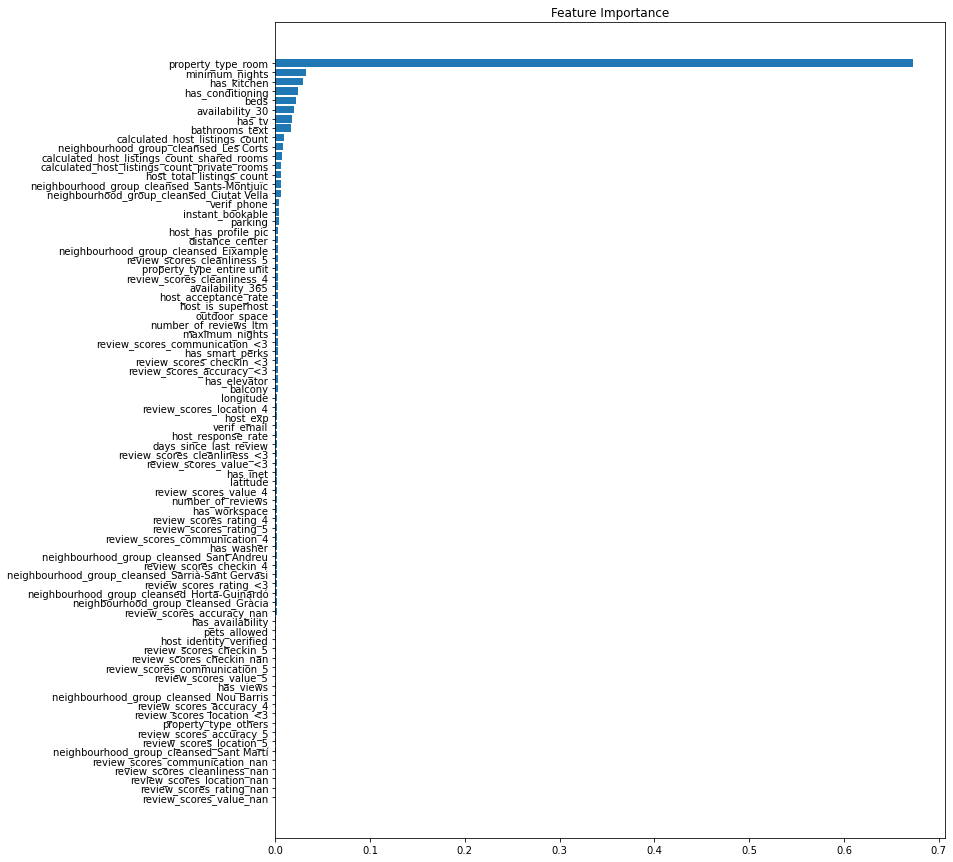

In [831]:
feature_importance = xg_reg.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 15))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X.columns)[sorted_idx])
plt.title('Feature Importance')


### Hyperparam tuning

In [838]:
from sklearn.model_selection import RandomizedSearchCV

#param grid
params = {'max_depth': [3, 6, 10, 15],
          'learning_rate': [0.01, 0.1, 0.2, 0.3, 0.4],
          'subsample': np.arange(0.5, 1.0, 0.1),
          'colsample_bytree': np.arange(0.5, 1.0, 0.1),
          'colsample_bylevel': np.arange(0.5, 1.0, 0.1),
          'n_estimators': [100, 250, 500, 1000, 2000],
          }

xgb_reg = xgb.XGBRegressor(objective='reg:squarederror')

clf = RandomizedSearchCV(estimator = xgb_reg,
                         param_distributions = params,
                         scoring = 'neg_mean_absolute_error',
                         n_jobs = -1,
                         cv = 4,
                         random_state = rs,
                         verbose = 50)

In [839]:
#As soon as we use cross validation we fit the entire feature set
clf.fit(sc.fit_transform(X), np.log1p(y))

Fitting 4 folds for each of 10 candidates, totalling 40 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   57.0s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   57.1s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:   57.6s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   57.6s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  3.

RandomizedSearchCV(cv=4,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, gamma=None,
                                          gpu_id=None, importance_type='gain',
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_estimators=100, n...
                                          verbosity=None),
                   n_jobs=-1,
                   param_distributions={'colsample_bylevel': array([0.5, 0.6, 0.7, 0.8, 0.9]),
      

In [840]:
clf.best_params_

{'subsample': 0.8999999999999999,
 'n_estimators': 2000,
 'max_depth': 15,
 'learning_rate': 0.01,
 'colsample_bytree': 0.6,
 'colsample_bylevel': 0.5}

In [845]:
y_pred = clf.best_estimator_.predict(X_test)
metrics(y_test, np.expm1(y_pred))

MAPE : 6.78%
RMSE : 156.4454


As you can see we have significantly increased the accuracy

## Conclusion

- The best model - tuned XGBoost Regressor with results:
    - MAPE: 6.78%
    - RMSE: 156 
    - This tells us that the mean absolute percent error between the price predicted by the model and the actual is 6.78%.
- Most important features:
    - property type
    - amenities
    - neighbourhoods
- Kitchen, conditioning, tv are considered as the most valuable ammenities

Save the model for the further work

In [863]:
#saving scaler and the model
output_file = f'model.bin'

f_out = open(output_file, 'wb') 
joblib.dump((sc, clf.best_estimator_), f_out)
f_out.close()

In [886]:
input_file = 'model.bin'

with open(input_file, 'rb') as f_in: 
    sc2, model2 = joblib.load(f_in)

Sample input file

In [862]:
pd.DataFrame(X.iloc[2500]).rename({2500:'value'}, axis = 1).to_csv('sample.csv')